# <center> **Developing a Classification ML Model using Dimension Reduction and using ML to identify biomarkers in Lung Cancer**

### <center> *By Aditya Subramanian*

***

##### **Dataset Used**: MTBLS28: Non-invasive urinary metabolomic profiling identifies diagnostic and prognostic markers in lung cancer<br>
##### **Research Paper Associated**: https://aacrjournals.org/cancerres/article/74/12/3259/592715/Noninvasive-Urinary-Metabolomic-Profiling<br>

##### **Abstract(taken from paper)**: <br> Lung cancer remains the most common cause of cancer deaths worldwide, yet there is currently a lack of diagnostic noninvasive biomarkers that could guide treatment decisions. Small molecules (<1500 Da) were measured in urine collected from 469 lung cancer patients and 536 population controls using unbiased liquid chromatography-mass spectrometry. Clinical putative diagnostic and prognostic biomarkers were validated by quantitation and normalized to creatinine levels at two different time points and further validated in an independent sample set, which comprises 80 cases and 78 population controls, with similar demographic and clinical characteristics when compared to the training set. Creatine riboside (IUPAC name: 2-{2-[(2R,3R,4S,5R)-3,4-dihydroxy-5-(hydroxymethyl)-oxolan-2-yl]-1-methylcarbamimidamido}acetic acid), a novel molecule identified in this study, and N-acetylneuraminic acid (NANA), were each significantly (P <0.00001) elevated in non–small cell lung cancer (NSCLC) and associated with worse prognosis (hazard ratio (HR) =1.81 [P =0.0002], and 1.54 [P =0.025], respectively). Creatine riboside was the strongest classifier of lung cancer status in all and stage I–II cases, important for early detection, and also associated with worse prognosis in stage I–II lung cancer (HR =1.71, P =0.048). All measurements were highly reproducible with intraclass correlation coefficients ranging from 0.82 – 0.99. Both metabolites were significantly (P <0.03) enriched in tumor tissue compared to adjacent non-tumor tissue (N =48), thus revealing their direct association with tumor metabolism. Creatine riboside and NANA may be robust urinary clinical metabolomic markers that are elevated in tumor tissue and associated with early lung cancer diagnosis and worse prognosis.

***

## **Section 1: Setup**

### 1.1 Imports and Settings

In [1]:
#all imports

#fundamental
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#phik
import phik
from phik import resources, report

#pca
from sklearn.decomposition import PCA

#umap
import umap
import umap.plot

#ml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import ml_analysis_custom
from sklearn.preprocessing import RobustScaler

#rf
from sklearn.ensemble import RandomForestClassifier

#SVM
from sklearn.svm import SVC

#lgbm
from lightgbm import LGBMClassifier

#logistic regression
from sklearn.linear_model import LogisticRegression

#imports for analysis
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics

#SHAP
import shap
shap.initjs()


In [2]:
#settings
sns.set_theme(style = 'white', context = 'notebook', rc = {'figure.figsize':(14,10)})

### 1.2 Read in and Preprocess Dataset

##### *df_quantities -> standard dataframe <br> df_quantities_2 -> dataframe with categorical values<br> df_quantities_mapped -> dataframe with mapped categorical values(same as df_quantities_2 except used for ML)*

In [3]:
#read in pos and neg tsv
df_pos = pd.read_csv("../MTBLS28_187567/m_MTBLS28_POS_v2_maf.tsv", sep = "\t")
df_neg = pd.read_csv("../MTBLS28_187567/m_MTBLS28_NEG_v2_maf.tsv", sep = "\t")

#set columns to be identical to enable concatenation
df_neg.columns = df_pos.columns
df_temp_1 = pd.concat([df_pos, df_neg], ignore_index=True)

In [4]:
#separate metabolites
df_metabolite_information = df_temp_1.iloc[:, [5, 9]]

#remove unnecessary columns from features and transpose
df_quantities = df_temp_1.drop(columns = df_temp_1.columns[0: 21]).transpose()

In [5]:
#read in next data table
df_temp_2 = pd.read_csv("../MTBLS28_187567/s_MTBLS28.txt", sep = "\t")
#set target
df_target = df_temp_2.iloc[0: 1005, 24]

In [6]:
# ===========================================================
# OPTIONAL CODE: Results do not include categorical variables
# ===========================================================

#add categorical
df_quantities.index = df_temp_2.index.values[0: 1005]
df_quantities_2 = pd.concat([df_quantities, df_temp_2.iloc[0: 1005, [15, 18, 21]]], axis=1)

#map categorical values to numbers
df_quantities_mapped = df_quantities_2.copy()
df_quantities_mapped['Factor Value[Smoking]'] = df_quantities_mapped['Factor Value[Smoking]'].map({'Current Smoker': 2, 'Former Smoker': 1, 'Never Smoker': 0})
df_quantities_mapped['Factor Value[Race]'] = df_quantities_mapped['Factor Value[Race]'].map({'European American': 1, 'African American': 0})
df_quantities_mapped['Factor Value[Gender]'] = df_quantities_mapped['Factor Value[Gender]'].map({'Male': 1, 'Female': 0})

### 1.3 Create Dimension Reduced Dataframes with PCA and UMAP

##### *df_quantities_pca -> pca reduced dataframe <br> df_quantities_umap -> umap reduced dataframe*

In [7]:
# ==== Settings: PCA ====
pca_n_components = 20
pca_dataset = df_quantities
pca_seed = 1

In [8]:
pca = PCA(n_components = pca_n_components, random_state = pca_seed)
principal_components = pca.fit_transform(pca_dataset)
df_quantities_pca = pd.DataFrame(data = principal_components)

In [9]:
# ==== Settings: UMAP ====
umap_dataset = df_quantities
umap_n_components = 20
umap_seed = 1

In [10]:
#standardize and apply umap
df_standard = StandardScaler().fit_transform(umap_dataset)
reducer = umap.UMAP(n_components = umap_n_components, random_state = umap_seed).fit(df_standard)

#store in embedding
df_quantities_umap = reducer.transform(df_standard)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 1.4 Create Test-Training Test split

#### **Applies to all train and test splits:** <br> *X_train -> original dataframe <br> X_train_pca -> pca reduced dataframe <br> X_train_umap -> umap reduced dataframe <br>*

In [11]:
# ==== Settings: Test-Train Split ====
proportion_for_testing = 0.25
seed_train_test_split = 1

In [12]:
## test train split

#split original dataframe into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_quantities, df_target, test_size = proportion_for_testing, random_state = seed_train_test_split)
#split pca reduced dataframe into train and test sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(df_quantities_pca, df_target, test_size = proportion_for_testing, random_state = seed_train_test_split)
#split umap reduced dataframe into train and test sets
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(df_quantities_umap, df_target, test_size = proportion_for_testing, random_state = seed_train_test_split)

***

## **Section 2: ML Models with Non-Dimensionally Reduced Data**

##### There are four different ml models -> RF, SVM, and LGBM: <br>

### 2.1 Create and Fit Models

In [13]:


# ==== Settings: SVM ====
svm_seed = 1
svm_train_features = X_train
svm_train_targets = y_train

# ==== Settings: LGBM ====
lgbm_seed = 1
lgbm_train_features = X_train
lgbm_train_targets = y_train

# ==== Settings: Log Reg ====
log_seed = 1
log_train_features = X_train
log_train_targets = y_train

In [14]:
##to fit into random forest classifier


#SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state = svm_seed))
])
svm_pipeline.fit(svm_train_features, svm_train_targets)


#lgbm pipeline
lgbm_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('lgbm', LGBMClassifier(random_state = lgbm_seed))
])

lgbm_pipeline.fit(lgbm_train_features, lgbm_train_targets)


#log pipeline
logreg_pipeline = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression(random_state=log_seed))
])
logreg_pipeline.fit(log_train_features, log_train_targets)

[LightGBM] [Info] Number of positive: 396, number of negative: 357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 795743
[LightGBM] [Info] Number of data points in the train set: 753, number of used features: 3166
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.525896 -> initscore=0.103678
[LightGBM] [Info] Start training from score 0.103678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('scaler', RobustScaler()),
                ('logreg', LogisticRegression(random_state=1))])

### **2.1 RF Model Initial Test and Analysis**

In [15]:
# ==== Settings: rf ====
rf_seed = 1
rf_train_features = X_train
rf_train_targets = y_train

In [16]:
#rf pipeline

rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=rf_seed))
])
rf_pipeline.fit(rf_train_features, rf_train_targets)

Pipeline(steps=[('rf', RandomForestClassifier(random_state=1))])

In [17]:
# ==== Settings: rf confusion matrix====
rf_test_features = X_test
rf_test_targets = y_test
rf_labels = ['Case', 'Control']
rf_matrix_title = 'RF Model Confusion Matrix'

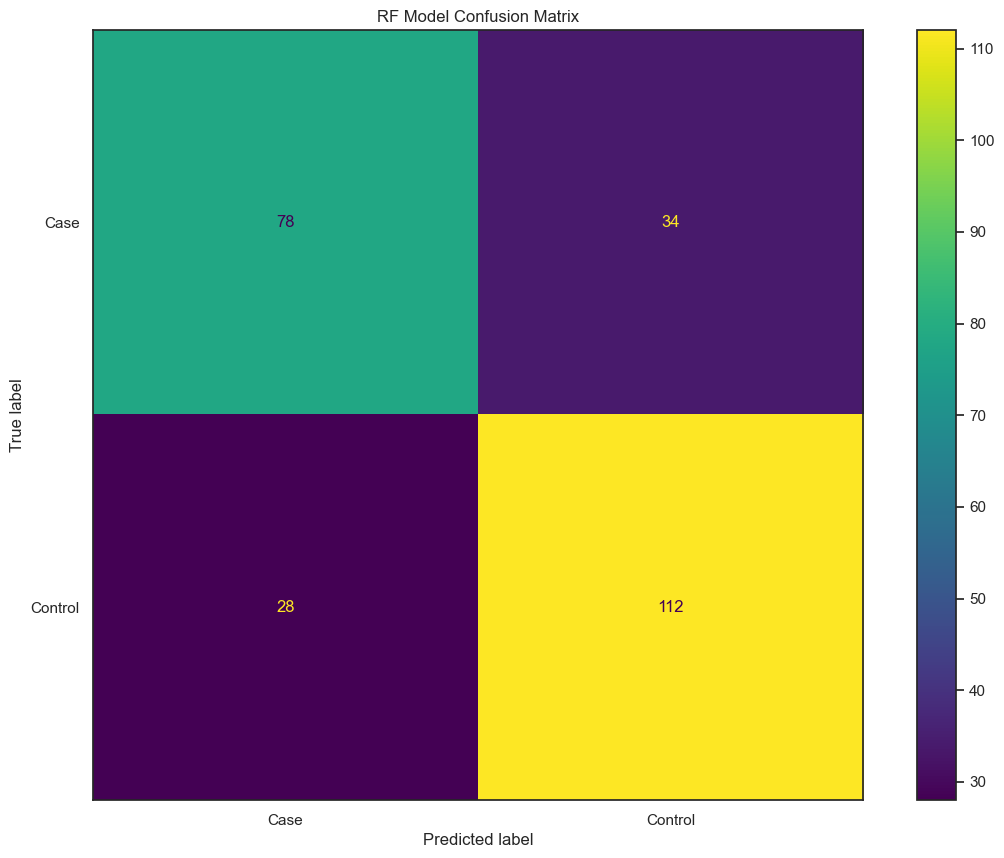

In [18]:
#run confusion matrix function
ml_analysis_custom.visualize_confusion_matrix(rf_pipeline, rf_test_targets, rf_test_features, rf_labels, rf_matrix_title)

##### **RF Model Confusion Matrix Analysis:** Based on the Confusion Matrix there was a false negative rate of about 13.5% and a false positive rate of 11.1%. While further analysis is needed these rates are mediocre compared to a very effective model

In [19]:
#save and visualize ml metrics
rf_results = ml_analysis_custom.estimate_ml_metrics(rf_pipeline, 'RF', y_test, X_test, 1000) #returns dictionary
print(pd.DataFrame([rf_results]).to_markdown(index=False))

| Model   |   Accuracy |   Precision |   Recall |       F1 | Latency                 |
|:--------|-----------:|------------:|---------:|---------:|:------------------------|
| RF      |   0.753968 |    0.753224 | 0.753968 | 0.753163 | 0.0083 ± 0.0011 seconds |


**RF Model ML Metrics**
| Model   |   Accuracy |   Precision |   Recall |       F1 | Latency                 |
|:--------|-----------:|------------:|---------:|---------:|:------------------------|
| RF      |   0.753968 |    0.753224 | 0.753968 | 0.753163 | 0.0078 ± 0.0012 seconds |

##### **RF Model ML Metrics Analysis**: The accuracy and precision is more than chance(0.5) yet is not accurate enough to be considered a good choice. Latency will be compared to other models later 

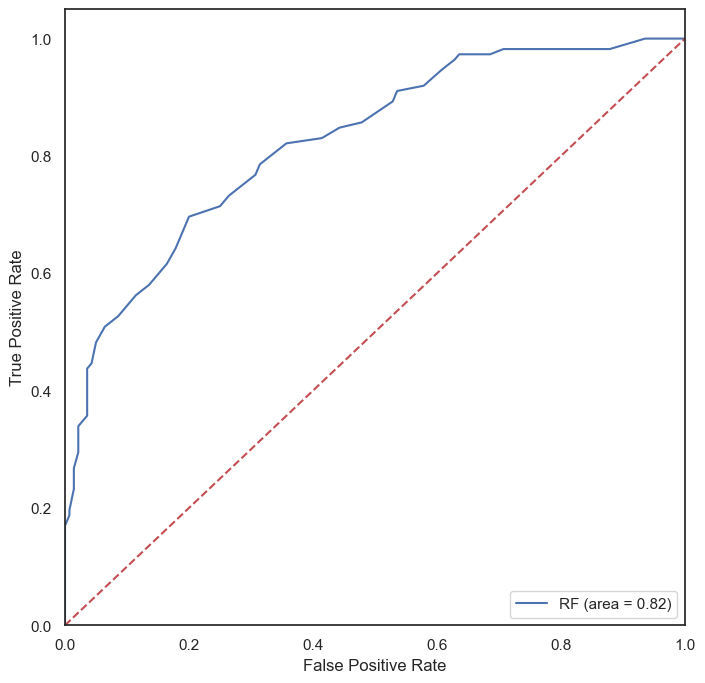

In [20]:
#visualize roc auc curve
ml_analysis_custom.create_ROC_curve(8, 8, ['RF'], [rf_pipeline], [X_test], 
                            [y_test], 'AUC-ROC Curve RF Model', 'Case')

##### **RF Model AUC ROC Analysis**: The AUC ROC curve indicates that model works satisfactorily as it is well above the threshold with an area of 0.82

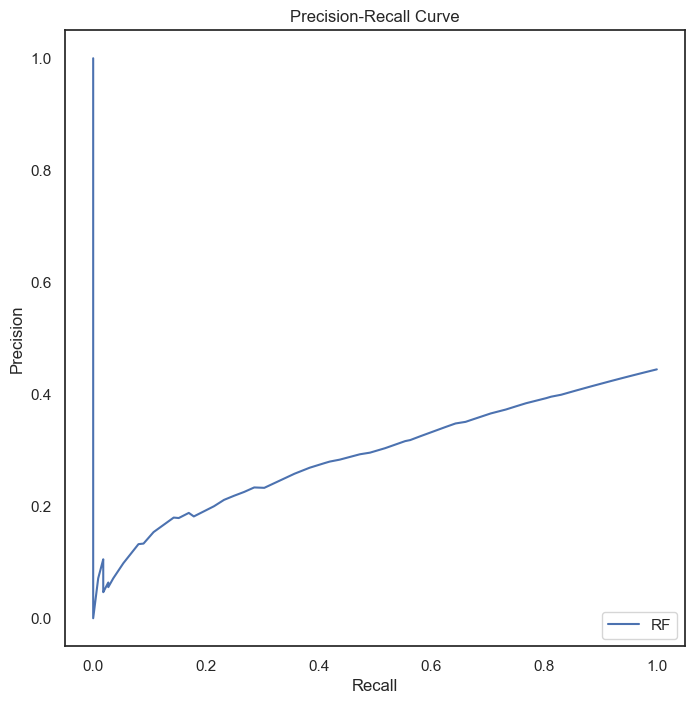

In [21]:
ml_analysis_custom.visualize_precision_recall_curve(8, 8, ['RF'], [rf_pipeline], [X_test], [y_test], 'Precision-Recall Curve', 'Case')

##### **Model RF Precision-Recall Curve**: The Precision-Recall curve reveals problems since an ideal precision-recall curve should start at a very high precision and show a roughly gradual decrease as recall increases. However this model uncharacteristically starts at high precision levels, rapidly decreases to low precision levels, and increases slowly as recall increases. The only model performs well at extremely low recall levels, which makes it unideal for use.

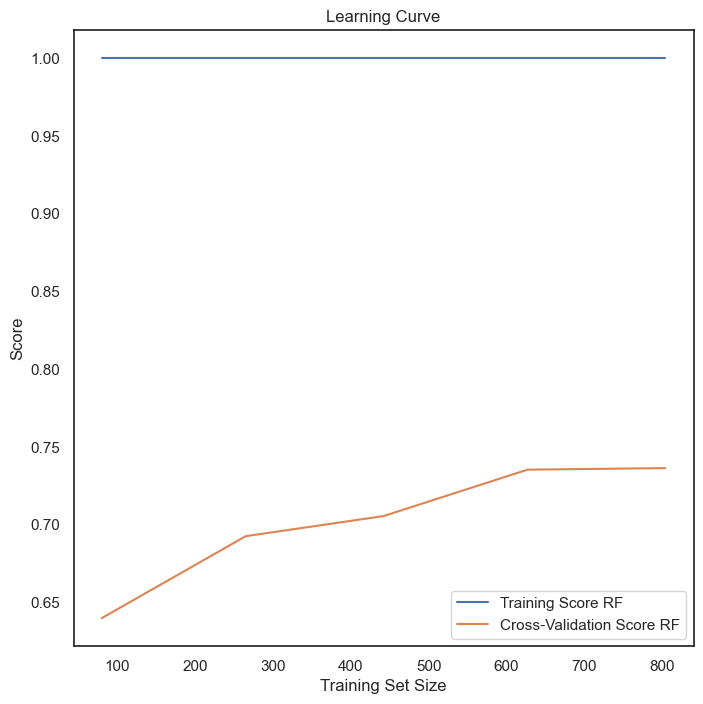

In [22]:
ml_analysis_custom.visualize_learning_curve_classification(8, 8, ['RF'], [rf_pipeline] , df_quantities, df_target, [0.1, 0.33, 0.55, 0.78, 1.0], 5)

##### **RF Model AUC ROC Analysis**: The Learning Curve further reveals issues as it shows that this model is significantly overfit due to the difference in train and cross_validation scores.

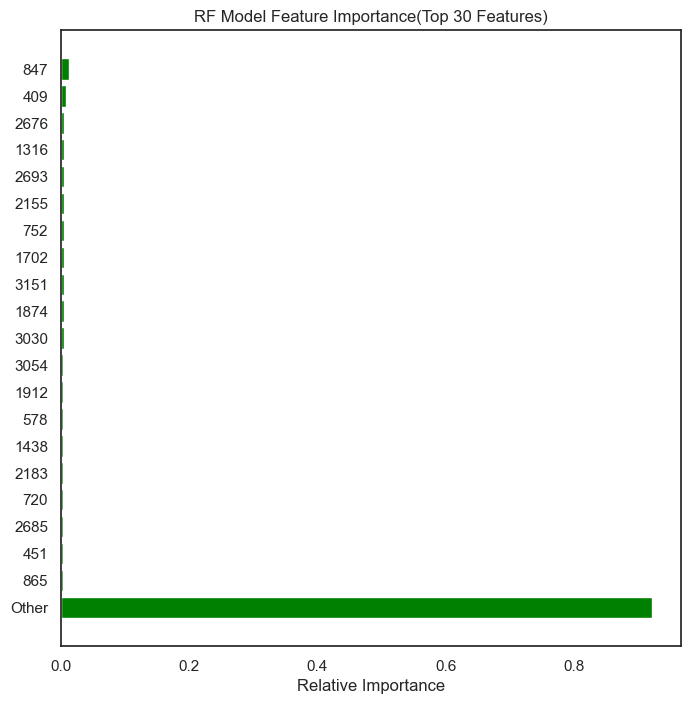

In [23]:
#visualize feature importance bar graph
ml_analysis_custom.visualize_feature_importance(8, 8, rf_pipeline.named_steps['rf'], 'RF Model Feature Importance(Top 30 Features)', 'green', df_quantities.columns.tolist(), 20)

##### **RF Model Feature Importance Analysis**: The Feature Importance reveals further issues with the model. No dominant predictors were revealed in the top 30 features as each have very  little relative importance. This means the model is diluted by unimportant features. RF parameters must be tuned, noise must be removed, or a different method must be used.

***
#### **RF Model Overall Analysis:** <br>While the model performs moderately well on base metrics, in-depth metrics revealed the model only performed well at unusual recall levels, was overfit, and had uniform gini impurity levels making further tuning a necessity
***

### 2.3 RF Model Tuned Test and Analysis

### 2.4 SVM Initial Test and Analysis

In [24]:
# ==== Settings: SVM confusion matrix====
svm_test_features = X_test
svm_test_targets = y_test
svm_labels = ['Case', 'Control']
svm_matrix_title = 'SVM Model Confusion Matrix'

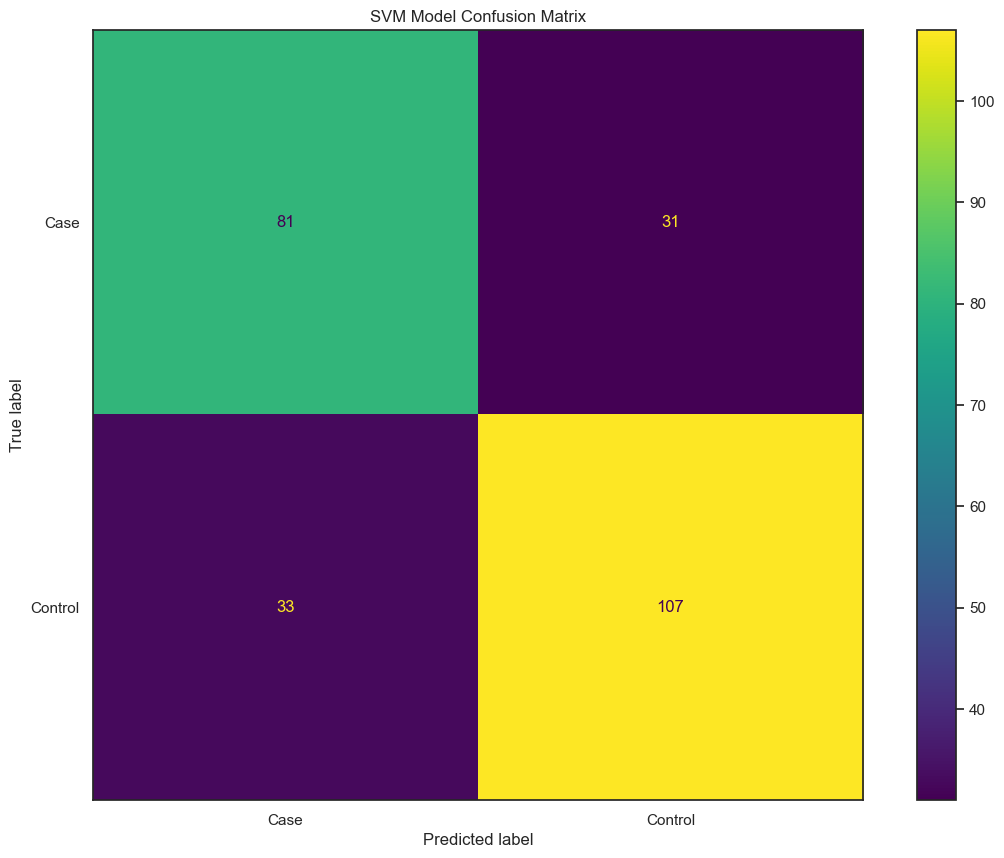

In [25]:
ml_analysis_custom.visualize_confusion_matrix(svm_pipeline, svm_test_targets, svm_test_features, svm_labels, svm_matrix_title)

##### **SVM Model Confusion Matrix Analysis:** Based on the Confusion Matrix performs 

In [36]:
#save and visualize ml metrics
svm_results = ml_analysis_custom.estimate_ml_metrics(svm_pipeline, 'SVM', y_test, X_test, 1000) #returns dictionary
print(pd.DataFrame([svm_results]).to_markdown(index=False))
SVC(random_state = svm_seed, kernel='rbf')

| Model   |   Accuracy |   Precision |   Recall |       F1 | Latency                 |
|:--------|-----------:|------------:|---------:|---------:|:------------------------|
| SVM     |   0.746032 |    0.746546 | 0.746032 | 0.746242 | 0.2527 ± 0.0324 seconds |


SVC(random_state=1)

### 2.5 SVM Tuned Test and Analysis

In [27]:
#SVM tuned
svm_tuned_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVC(random_state = svm_seed))
])
svm_tuned_pipeline.fit(svm_train_features, svm_train_targets)


Pipeline(steps=[('scaler', RobustScaler()), ('svm', SVC(random_state=1))])

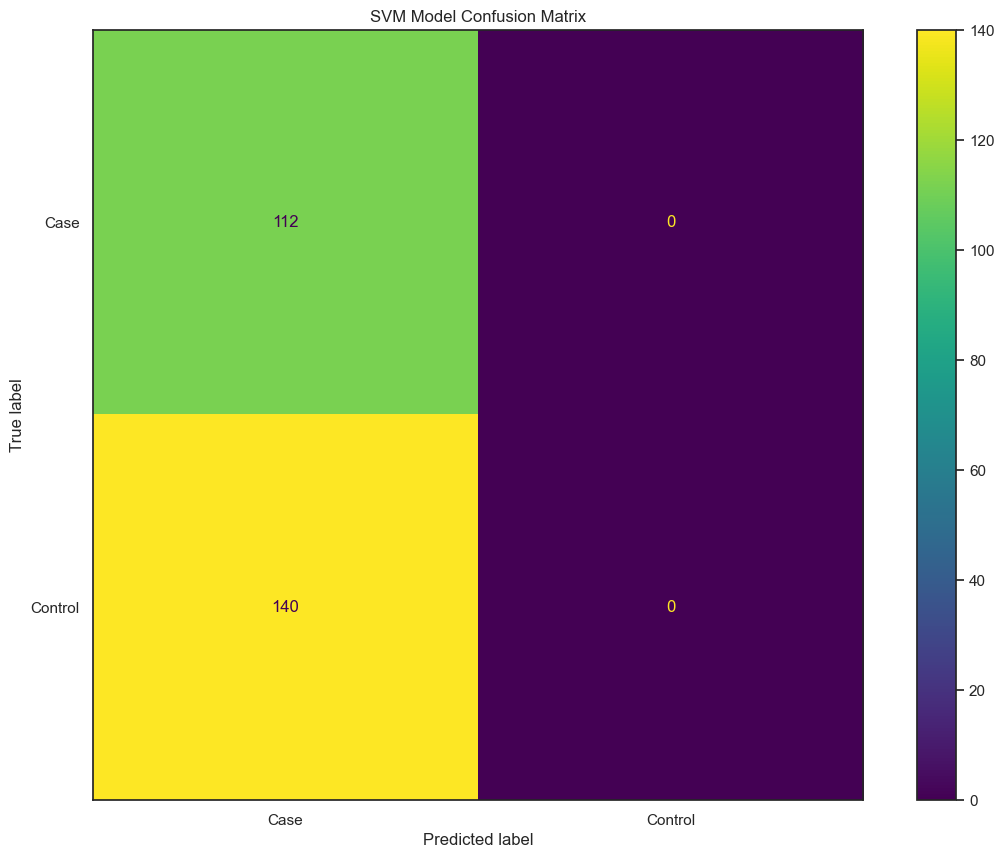

In [28]:
ml_analysis_custom.visualize_confusion_matrix(svm_tuned_pipeline.named_steps['svm'], svm_test_targets, svm_test_features, svm_labels, svm_matrix_title)

In [29]:
# ==== Settings: LGBM confusion matrix====
lgbm_test_features = X_test
lgbm_test_targets = y_test
lgbm_labels = ['Case', 'Control']
lgbm_matrix_title = 'LGBM Model Confusion Matrix'

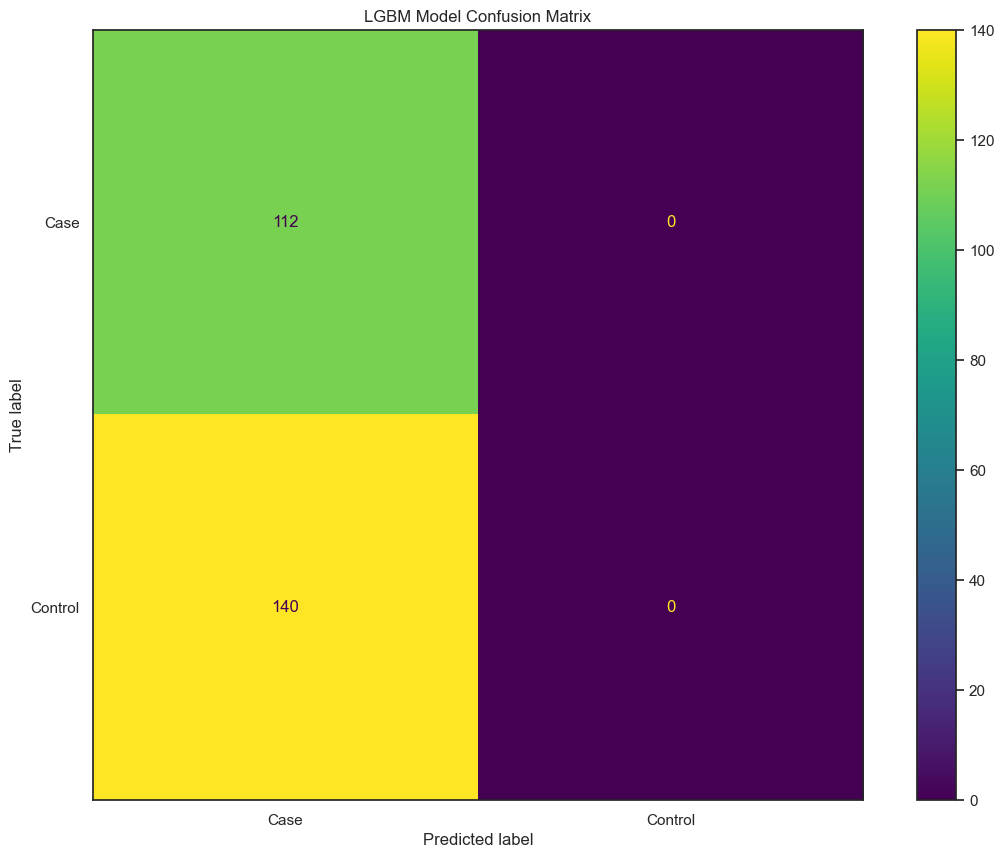

In [30]:
ml_analysis_custom.visualize_confusion_matrix(lgbm_pipeline.named_steps['lgbm'], lgbm_test_targets, lgbm_test_features, lgbm_labels, lgbm_matrix_title)

In [31]:
# ==== Settings: LGBM confusion matrix====
log_test_features = X_test
log_test_targets = y_test
log_labels = ['Case', 'Control']
log_matrix_title = 'Logistic Regression Model Confusion Matrix'

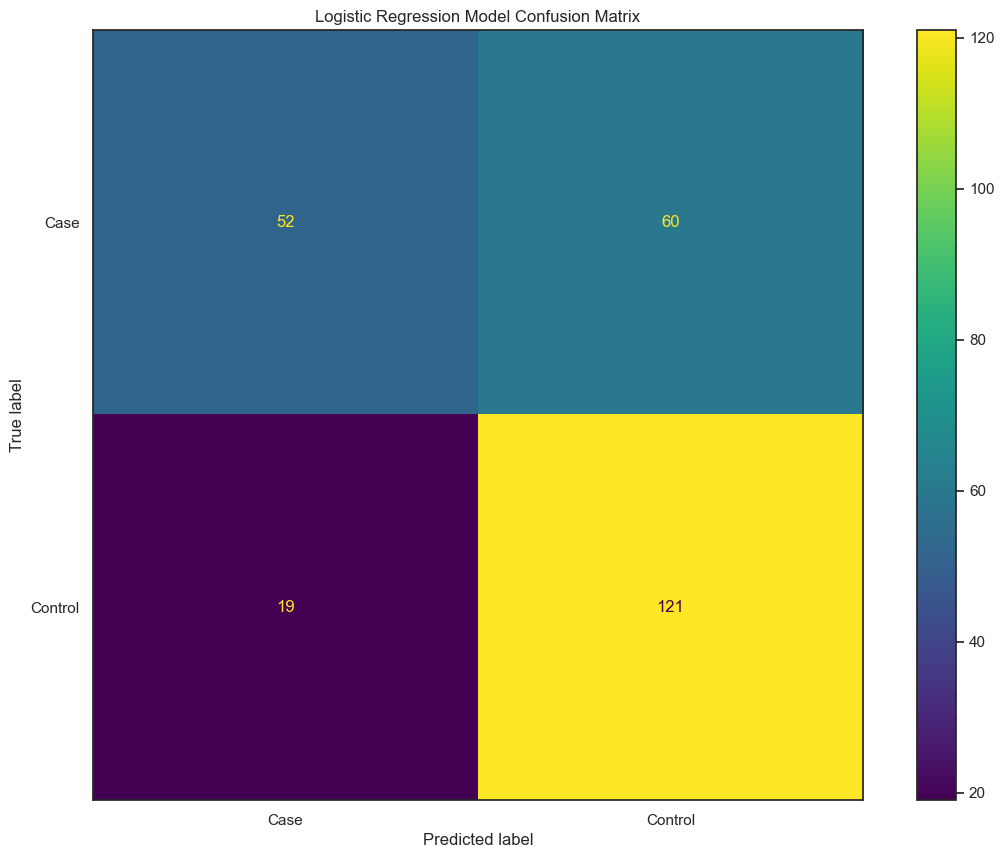

In [32]:
ml_analysis_custom.visualize_confusion_matrix(logreg_pipeline.named_steps['logreg'], log_test_targets, log_test_features, log_labels, log_matrix_title)

In [33]:
#save and visualize ml metrics
rf_results = ml_analysis_custom.estimate_ml_metrics(logreg_pipeline.named_steps['logreg'], 'LG', y_test, X_test, 1000) #returns dictionary
print(pd.DataFrame([rf_results]).to_markdown(index=False))

| Model   |   Accuracy |   Precision |   Recall |      F1 | Latency                 |
|:--------|-----------:|------------:|---------:|--------:|:------------------------|
| LG      |   0.686508 |    0.696902 | 0.686508 | 0.67141 | 0.0074 ± 0.0043 seconds |


| Model   |   Accuracy |   Precision |   Recall |       F1 | Latency                 |
|:--------|-----------:|------------:|---------:|---------:|:------------------------|
| LG      |   0.654762 |    0.656277 | 0.654762 | 0.641975 | 0.0066 ± 0.0029 seconds |